# How Big of an Influence is Player Physique in the Game of Professional Basketball?

<i>Created by <b>Michael Bartner</b></i>

## Introduction

One of the toughest moments in many young basketball players' lives is recognizing that they don't have the physique to follow their dreams to becoming a basketball star. In a game built around tranlating a ball from a player's hands to a metal hoop located ten feet above the ground, it is easy to see how advantageous a player's height and weight can be.

Yet, even NBA teams composed of players whose standing reaches (the heigh of a player with their arms erect) are merely inches from the rim have been defeated, and teams utilizing players like Tyrone “Muggsy” Bogues, who stood at only 5'3 (yes, there is still hope!), can emerge victorious.

Today, we will uncover how impactful a player physique is on their team's success through the analysis of NBA team and player data from the past 10 full seasons of NBA basketball.

## Getting Started

### Required Libraries

The following libraries will assist us on our conquest:

    Requests    - Retrieving data from the NBA database
    Time        - Sleep function (more on this later)
    Numpy       - Generating random numbers
    Pandas      - Organize and manipulate data
    Matplotlib  - Plotting data
    ggplot      - Violin plots
    sklearn     - Fitting regression lines
    statsmodels - Interaction term

In [1]:
import requests
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.formula.api as smf
matplotlib.style.use('ggplot')

### Retrieving the Data

To begin our endeavor, we will need to obtain the data on both NBA teams and players. Datasets aren't always easy to find and may require you to apply some ad-hoc methodology to obtain what you're looking for. The story behind this particular dataset starts from https://stats.nba.com. I quickly found the necessary data on their website, and decided I would just parse the html from the website. However, I slowly realized that the data was loaded after the website's inital page was loaded, meaning it wouldn't appear with a single query to the page. Using <a href="https://developers.google.com/web/tools/chrome-devtools/">Chrome's web inspector</a>, I traced the subsequent requests to a separate path on the website that accepted queries and responded with data formatted in <a href="https://en.wikipedia.org/wiki/JSON">JSON</a>.

This annoyance was a blessing in disguise, as it made the data far more easier to process than it would have to parse each unpredicatable line of the html. Of course with some caveats.

The following code conveys the process of retrieving NBA team and player data from the last 10 full seasons and saving the JSON response, in a dictionary keyed by season, to be processed afterward. More detail in the code comments.

In [2]:
player_data = {}   # Mapping of season to it's player data formatted in JSON
team_data = {}     # Mapping of season to it's team data formatted in JSON
for year in range(2008, 2018):
    season = str(year) + "-" + "{:02d}".format((year + 1) % 100) # Create string formatting the site 
                                                                 # uses for season queries
    # Headers are additional data your browser usually sends with http requests
    # stats.nba.com elected to not respond to queries that came without some of these headers,
    # so I left them all in to be safe. This can be used for both the player and team queries.
    headers = {"Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
               "Accept-Encoding": "gzip, deflate, br",
               "Accept-Language": "en-US,en;q=0.9",
               "Cache-Control": "max-age=0",
               "Connection": "keep-alive",
               "DNT": "1",
               "Host": "stats.nba.com",
               "Upgrade-Insecure-Requests": "1",
               "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.110 Safari/537.36"
              }

    players_url = "https://stats.nba.com/stats/leaguedashplayerbiostats" # Path to player data
    # Player query parameters, you can alter these for to filter results
    # Note that there are restrictions on your query, ex: can't query all seasons
    players_params = {
        'College':'',
        'Conference':'',
        'Country':'',
        'DateFrom':'',
        'DateTo':'',
        'Division':'',
        'DraftPick':'',
        'DraftYear':'',
        'GameScope':'',
        'GameSegment':'',
        'Height':'',
        'LastNGames':'0',
        'LeagueID':'00',
        'Location':'',
        'Month':'0',
        'OpponentTeamID':'0',
        'Outcome':'',
        'PORound':'0',
        'PerMode':'PerGame',
        'Period':'0',
        'PlayerExperience':'',
        'PlayerPosition':'',
        'Season': season,
        'SeasonSegment':'',
        'SeasonType':'Regular Season',
        'ShotClockRange':'',
        'StarterBench':'',
        'TeamID':'0',
        'VsConference':'',
        'VsDivision':'',
        'Weight':''
    }
    
    # Send the request and make sure response was successful
    players_resp = requests.get(url=players_url,
                                headers=headers,
                                params=players_params,
                                json={"key": "value"}
                               )
    if players_resp.status_code != 200:
        raise Exception("Failed to retrieve player data for season:" + season)
        
    # Add data to a dictionary for future processing and append the season start and end year to maintain record
    player_data[season] = players_resp.json()
    for player in player_data[season]['resultSets'][0]['rowSet']:
        player.append(year)
        player.append(year + 1)
        
    team_url = "https://stats.nba.com/stats/leaguedashteamstats" # Path to team data
    # Team query parameters
    team_params = {
        'Conference':'',
        'DateFrom':'',
        'DateTo':'',
        'Division':'',
        'GameScope':'',
        'GameSegment':'',
        'LastNGames':'0',
        'LeagueID':'00',
        'Location':'',
        'MeasureType':'Base',
        'Month':'0',
        'OpponentTeamID':'0',
        'Outcome':'',
        'PORound':'0',
        'PaceAdjust':'N',
        'PerMode':'PerGame',
        'Period':'0',
        'PlayerExperience':'',
        'PlayerPosition':'',
        'PlusMinus':'N',
        'Rank':'N',
        'Season':season,
        'SeasonSegment':'',
        'SeasonType':'Regular Season',
        'ShotClockRange':'',
        'StarterBench':'',
        'TeamID':'0',
        'TwoWay':'0',
        'VsConference':'',
        'VsDivision':''
    }
    
    # Send the request and make sure response was successful
    team_resp = requests.get(url=team_url,
                             headers=headers,
                             params=team_params,
                             json={"key": "value"}
                            )
    if team_resp.status_code != 200:
        raise Exception("Failed to retrieve team data for season:" + season)
    
    # Add data to a dictionary for future processing and append the season start and end year to maintain record
    team_data[season] = team_resp.json()
    for team in team_data[season]['resultSets'][0]['rowSet']:
        team.append(year)
        team.append(year + 1)
    
    time.sleep(2) # To many queries will result in temporary ban

### Preparing and Tidying the Data

Now that we have our data, we want to reorganize it into a Pandas DataFrame to facilitate future analysis. Fortunately, Python understands JSON natively, so when we mapped the data into a dictionary, it was converted to a nest of lists and dictionaries. Let's look at how the player data was formatted for 2008-09.

In [3]:
player_data["2008-09"].keys()

dict_keys(['resource', 'parameters', 'resultSets'])

<i>Resource</i> corresponds to the location we asked for the data from and <i>parameters</i> are our query parameters, so <i>resultSets</i> must be what we are looking for. Our query only responded with one result set, so let's see what we are working with in the first set.

In [4]:
player_data["2008-09"]['resultSets'][0].keys()

dict_keys(['name', 'headers', 'rowSet'])

<i>Name</i> refers to the title of the dataset, but we are more interested in <i>headers</i> and <i>rowSet</i>. <i>Headers</i> will correspond to the names of each column in the dataset, while <i>RowSet</i> will hold the data of each player with respect to the column headers. Recall that when retrieving our data, we added the season start and season end year to each player's data, so we will need to add the additional column headers manually.

Let's create a DataFrame for each season, while simultaneously merging them into a single data frame. And then take a look of what kind of data we have.

In [5]:
player_df = None

# Create a dataframe for each season's data and merge them into a single dataframe
for season in player_data:
    # Add our additional columns manually
    columns = player_data[season]['resultSets'][0]['headers'] + ["SEASON_START", "SEASON_END"]
    # Create a new DataFrame if no data has been processed yet
    if player_df is None:
        player_df = pd.DataFrame(columns=columns)
    # Append the seasons data to the new DataFrame, ignore_index allows each row to have a unique index
    player_df = player_df.append(pd.DataFrame(data=player_data[season]['resultSets'][0]['rowSet'], columns=columns),
                                 ignore_index=True
                                )

# Let's look at our data types
player_df.dtypes

PLAYER_ID                object
PLAYER_NAME              object
TEAM_ID                  object
TEAM_ABBREVIATION        object
AGE                     float64
PLAYER_HEIGHT            object
PLAYER_HEIGHT_INCHES     object
PLAYER_WEIGHT            object
COLLEGE                  object
COUNTRY                  object
DRAFT_YEAR               object
DRAFT_ROUND              object
DRAFT_NUMBER             object
GP                       object
PTS                     float64
REB                     float64
AST                     float64
NET_RATING              float64
OREB_PCT                float64
DREB_PCT                float64
USG_PCT                 float64
TS_PCT                  float64
AST_PCT                 float64
SEASON_START             object
SEASON_END               object
dtype: object

<i>*Check out https://stats.nba.com/help/glossary/ if you are unfamiliar with any column headers</i>

Now we can see the data we are working with, but something is off. Why are numeric columns, like GP (Games Played), object type? Let's fix this, excluding columns we know shouldn't be numbers. (I also assigned colors to individual players for future graphs.)

In [6]:
# Iterate over each column
for col in player_df.columns:
    # Disregard non-numeric columns (Draft related columns can include "Undrafted" as a value,
    #                                but we won't be working with these columns regardless)
    if col in ["PLAYER_NAME", "TEAM_ABBREVIATION", "PLAYER_HEIGHT", "COLLEGE", "COUNTRY", "DRAFT_YEAR", "DRAFT_ROUND", "DRAFT_NUMBER"]:
        continue
    # use pandas to make the columns numeric and reassign them in the DataFrame
    player_df[col] = pd.to_numeric(player_df[col])

# Add random colors to each player
colors = {}
for player in player_df['PLAYER_ID'].unique():
    colors[player] = colors[player] = np.random.rand(3,)
player_df['Color'] = player_df.apply(lambda row: colors[row['PLAYER_ID']],axis=1)
    

player_df.dtypes

PLAYER_ID                 int64
PLAYER_NAME              object
TEAM_ID                   int64
TEAM_ABBREVIATION        object
AGE                     float64
PLAYER_HEIGHT            object
PLAYER_HEIGHT_INCHES    float64
PLAYER_WEIGHT           float64
COLLEGE                  object
COUNTRY                  object
DRAFT_YEAR               object
DRAFT_ROUND              object
DRAFT_NUMBER             object
GP                        int64
PTS                     float64
REB                     float64
AST                     float64
NET_RATING              float64
OREB_PCT                float64
DREB_PCT                float64
USG_PCT                 float64
TS_PCT                  float64
AST_PCT                 float64
SEASON_START              int64
SEASON_END                int64
Color                    object
dtype: object

It looks better, but there are still some datatypes we should be concerned about. Why do we need float values to keep track of a players height in inches? I highly doubt the NBA tracks fraction of inches of players. This could indicate some missing values, let's take a look.

In [7]:
indices = []
for index, row in player_df.iterrows():
    should_print = False
    if np.isnan(row["PLAYER_HEIGHT_INCHES"]):
        should_print = True
    if np.isnan(row["PLAYER_WEIGHT"]):
        should_print = True
    if should_print:
        indices.append(index)
        print(str(index) + ": " + row['PLAYER_NAME'] + ", Height:" + str(row['PLAYER_HEIGHT_INCHES']) + ", Weight: " + str(row['PLAYER_WEIGHT']))

2907: Elliot Williams, Height:nan, Weight: nan
2984: Jeff Adrien, Height:nan, Weight: nan
2996: Jerrelle Benimon, Height:nan, Weight: nan
3141: Patrick Christopher, Height:nan, Weight: nan
3252: Will Cherry, Height:nan, Weight: nan


It seems as though we have found the culprits. We could drop these players from our set, but we want to produce the most accurate results possible. Since there are so few players with missing data, I took the liberty of researching the correct data for myself (Source: Google "player_name height and weight"):

        Player              Height(in)   Weight(lbs)
    Elliot Williams    :      77           181  
    Jeff Adrien        :      79           245
    Jerrelle Benimon   :      80           245
    Patrick Christopher:      77           209
    Will Cherry        :      73           176
    
Unfortunately, this means our data might be slightly skewed if the players have fluctuated in weight (more likely) or height, but it is probably the best form of imputation we could have performed. Let's add these into our DataFrame.

In [8]:
heights = [77, 79, 80, 77, 73]
weights = [181, 245, 245, 209, 176]
i = 0
# Impute the new data
for index in indices:
    player_df.at[index, 'PLAYER_HEIGHT_INCHES'] = heights[i]
    player_df.at[index, 'PLAYER_WEIGHT'] = weights[i]

Looks good. Let's repeat a similar process with the NBA team datasets.

In [9]:
team_df = None
# Create a dataframe for each season's data and merge them into a single dataframe
for k in team_data:
    # Add our additional columns manually
    columns = team_data[k]['resultSets'][0]['headers'] + ["SEASON_START", "SEASON_END"]
    # Create a new DataFrame if no data has been processed yet
    if team_df is None:
        team_df = pd.DataFrame(columns=columns)
    # Append the seasons data to the new DataFrame, ignore_index allows each row to have a unique index
    team_df = team_df.append(pd.DataFrame(data=team_data[k]['resultSets'][0]['rowSet'], columns=columns),
                             ignore_index=True
                            )

# Iterate over each column
for col in team_df.columns:
    # Disregard non-numeric columns
    if col in ["TEAM_NAME", "CFPARAMS"]:
        continue
    # use pandas to make the columns numeric and reassign them in the DataFrame
    team_df[col] = pd.to_numeric(team_df[col])

# Add random colors to each team
colors = {}
for team in team_df['TEAM_ID'].unique():
    colors[team] = colors[team] = np.random.rand(3,)
team_df['Color'] = team_df.apply(lambda row: colors[row['TEAM_ID']],axis=1)
    
team_df.dtypes

TEAM_ID              int64
TEAM_NAME           object
GP                   int64
W                    int64
L                    int64
W_PCT              float64
MIN                float64
FGM                float64
FGA                float64
FG_PCT             float64
FG3M               float64
FG3A               float64
FG3_PCT            float64
FTM                float64
FTA                float64
FT_PCT             float64
OREB               float64
DREB               float64
REB                float64
AST                float64
TOV                float64
STL                float64
BLK                float64
BLKA               float64
PF                 float64
PFD                float64
PTS                float64
PLUS_MINUS         float64
GP_RANK              int64
W_RANK               int64
L_RANK               int64
W_PCT_RANK           int64
MIN_RANK             int64
FGM_RANK             int64
FGA_RANK             int64
FG_PCT_RANK          int64
FG3M_RANK            int64
F

<i>Interesting Note:</i> Players and teams have changed names throughout their time in the NBA, especially within the last 10 years, for example Metta World Peace (originally Ronald William Artest Jr. prior to 2011) and the New Orleans Pelicans (originally Hornets prior to 2014). The TEAM_ID and PLAYER_ID columns provide a way to maintain historical statitstics despite these changes.

### Reviewing the Data

Now that we've composed our DataFrame and know the types of data we are working with, let's quickly review the first row of data in each set before jumping into to some analysis.

In [10]:
print("-"*29 + " Player Row " + "-"*29)
print(player_df.loc[[0]].T) # Transpose to avoid the notebook hiding columns
print("\n\n" + "-"*30 + " Team Row " + "-"*30)
print(team_df.loc[[0]].T)  # Transpose to avoid the notebook hiding columns

----------------------------- Player Row -----------------------------
                                                                      0
PLAYER_ID                                                        201166
PLAYER_NAME                                                Aaron Brooks
TEAM_ID                                                      1610612745
TEAM_ABBREVIATION                                                   HOU
AGE                                                                  24
PLAYER_HEIGHT                                                       6-0
PLAYER_HEIGHT_INCHES                                                 72
PLAYER_WEIGHT                                                       161
COLLEGE                                                          Oregon
COUNTRY                                                             USA
DRAFT_YEAR                                                         2007
DRAFT_ROUND                                                      

Something to note is that both dataframes contain the "TEAM_ID" and "SEASON_START/END" fields. This will allow us to relate players to their teams for our analysis. Furthermore, we will be most interested in the physical attributes within our player DataFrame and the win/loss data within our team DataFrame to answer whether or not team's player physique influences the team's success, but don't count other attributes just yet.

## Exploratory Analysis, Viz, Hypothesis Testing

### 2.1 Observing Heights and Weights of NBA Players <a name='2_1' />

To transition into our analysis phase, let's first shape our understanding of the data we have collected. By constructing a violin plot we can see the distribution of heights and weights over the past ten years. Additionally, viewing a summary of the data will give us some insight on some questions we might come across in the future.

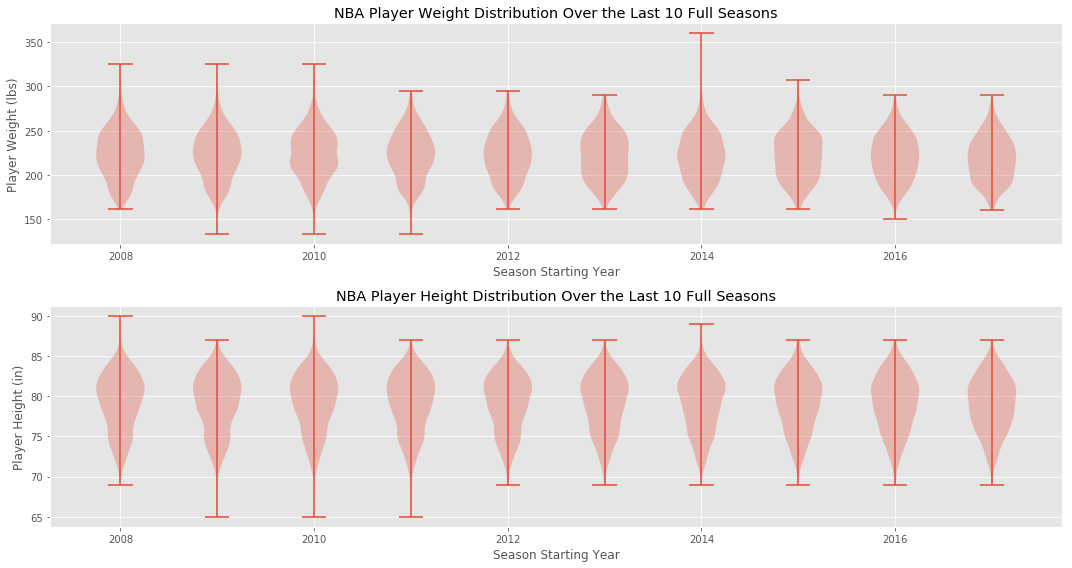

,PLAYER_ID,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT
count,4.762000e+03,4762.000000,4762.000000
mean,2.616080e+05,79.081898,221.710626
std,4.224417e+05,3.507607,26.755434
min,8.700000e+01,65.000000,133.000000
25%,2.754000e+03,77.000000,200.000000
50%,2.015860e+05,79.000000,220.000000
75%,2.030780e+05,82.000000,240.000000
max,1.628935e+06,90.000000,360.000000


In [11]:
def height_weight_per_year(df):
    # The Violin plot requires a 2D array of values.
    # The code below will create a list of lists composed of each seasons' players' weights
    weight = []
    for index, grp in df.groupby(['SEASON_START']):
        weight.append(grp['PLAYER_WEIGHT'].values)

    fig = plt.figure(figsize=(15,8)) # Set the size of the plot
    # Format the plot display area for multiple plots and add the first subplot
    ax1 = fig.add_subplot(2,1,1,
                          title="NBA Player Weight Distribution Over the Last 10 Full Seasons",
                          xlabel="Season Starting Year",
                          ylabel="Player Weight (lbs)"
                         )
    ax1.violinplot(weight, range(2008, 2018)) # Create the plot
    
    # Code above replicated for heights
    height = []
    for index, grp in df.groupby(['SEASON_START']):
        height.append(grp['PLAYER_HEIGHT_INCHES'].values)

    ax2 = fig.add_subplot(2,1,2,
                          title="NBA Player Height Distribution Over the Last 10 Full Seasons",
                          xlabel="Season Starting Year",
                          ylabel="Player Height (in)"
                         )
    ax2.violinplot(height, range(2008, 2018))
    
    plt.tight_layout() # Keep plots from overlapping
    plt.show() # Display the plots

height_weight_per_year(player_df)
player_df[['PLAYER_ID','PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT']].describe() # Present a summary of the dataset

Alrighty. It seems we have a mean height of 79 inches (6'7) and an average weight of about 222 pounds over the 10 year period, with relatively low standard deviations for both attributes. However, the 10 year averages might be slightly skewed based off the fact that some players have been in the league longer than others, and as a result, their attributes carry more weight. Luckily, visual analysis of the violin plots for both the heights and weights depict very conistent data, which makes sense considering those players that stay in the league for multiple years as well as the fact that players tend not to flucuate too much in weight and, especially, height. Still, teams are constantly trading players around in an effort to strategically move toward a more successful team. Let's inspect some of the tallest and heaviest teams in the league and some other relevant features.

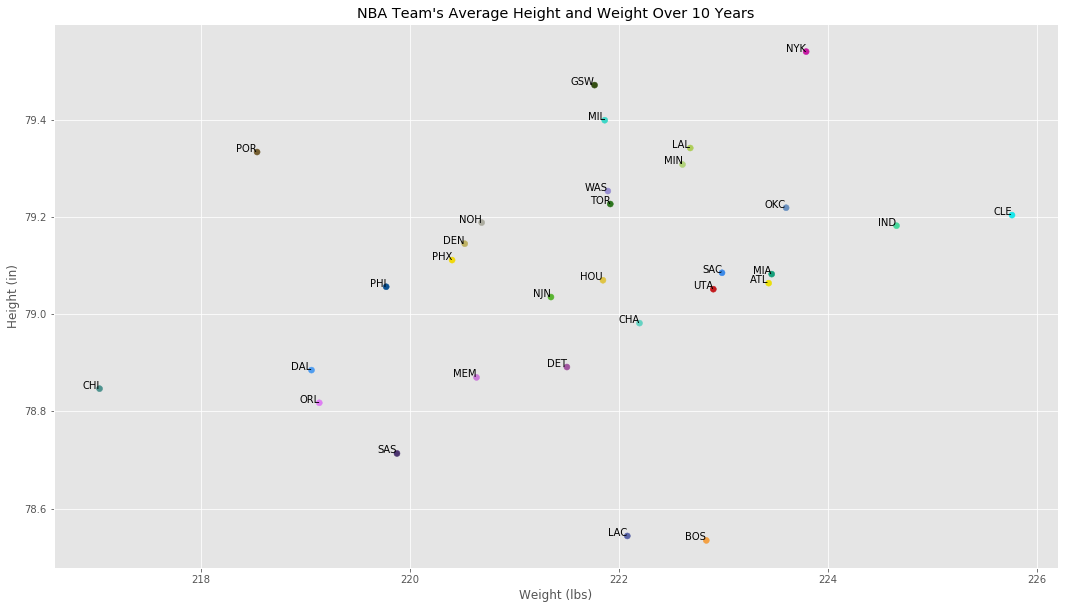

Height Range: 1.0052861056449416
Weight Range: 8.727145708582839


In [12]:
def avg_height_weight_per_team(p_df, t_df):
    mean_h_w = {} # Mapping of teams to a list of their player's mean weight, height, 
                  # color (for plotting), and abbreviation (for plotting)
    count = 0 # Used to index cleanly
    # Separate the players by team and iterate through the resulting groups
    for team, grp in p_df.groupby(['TEAM_ID']):
        clr = None # Track the team color for plotting
        for index, row in t_df.iterrows():
            if team == row['TEAM_ID']:
                clr = row['Color']
                break
        tm_abrv = None # Track the team abbreviation for plotting
        for player, row in grp.iterrows():
            tm_abrv = row['TEAM_ABBREVIATION']
            break
        # Add the data to the dictionary
        mean_h_w[count] = [grp['PLAYER_WEIGHT'].mean(), grp['PLAYER_HEIGHT_INCHES'].mean(), clr, tm_abrv]
        count += 1

    # Create a dataframe of the means and additional attributes
    h_w_df = pd.DataFrame.from_dict(mean_h_w,
                                    columns=['PLAYER_WEIGHT', 'PLAYER_HEIGHT_INCHES', 'Color', 'TEAM_ABBREVIATION'],
                                    orient="index"
                                   )
   
    fig = plt.figure(figsize=(18,10)) # Configure plot size
    # Add the subplot with proper labels
    ax = fig.add_subplot(1,1,1,
                         title="NBA Team's Average Height and Weight Over 10 Years",
                         xlabel="Weight (lbs)",
                         ylabel="Height (in)")
    # Plot the data
    ax.scatter(x=h_w_df['PLAYER_WEIGHT'],
               y=h_w_df['PLAYER_HEIGHT_INCHES'],
               color=h_w_df['Color'])
    # Label each point to identify the team
    for line in range(0,h_w_df.shape[0]):
        ax.text(h_w_df.PLAYER_WEIGHT[line],
                h_w_df.PLAYER_HEIGHT_INCHES[line],
                h_w_df.TEAM_ABBREVIATION[line],
                horizontalalignment='right',
                color='black'
               )

    plt.show()
    
    extreme_heights = [None, None]
    extreme_weights = [None, None]
    for key in mean_h_w.keys():
        if extreme_heights[0] == None:
            extreme_weights = [mean_h_w[key][0], mean_h_w[key][0]]
            extreme_heights = [mean_h_w[key][1], mean_h_w[key][1]]
        else:
            if extreme_weights[0] > mean_h_w[key][0]:
                extreme_weights[0] = mean_h_w[key][0]
            elif  extreme_weights[1] < mean_h_w[key][0]:
                extreme_weights[1] = mean_h_w[key][0]
                
            if extreme_heights[0] > mean_h_w[key][1]:
                extreme_heights[0] = mean_h_w[key][1]
            elif extreme_heights[1] < mean_h_w[key][1]:
                extreme_heights[1] = mean_h_w[key][1]
    print("Height Range: " + str(extreme_heights[1] - extreme_heights[0]))
    print("Weight Range: " + str(extreme_weights[1] - extreme_weights[0]))
    
avg_height_weight_per_team(player_df, team_df)

The top 2 tallest teams are the New York Knicks and the Golden State Warriors, while the heaviest team is the Cleveland Cavaleirs. The Warriors and Cavaleirs have been the two top contenters for the finals in recent years, so perhaps we are on to something. However, looking at the ranges, the teams are only an inch on average apart and only eight pounds apart! Let's fit a line to player heights against wins and player weights against wins just to check if there is any sign of a relationship.

### Searching for Relationships

First, we need calculate the average height and weight of each team per season. To ease future computations, we will add these values to our teams DataFrame.

In [13]:
means_per_team_per_season = {} # Map arbitrary index to team ID, season start, average height,
                               # average weight, and team abbreviation
count = 0 # Arbitrary index
# Sort the players by season and team and iterate through the groups
for (team, season_start), grp in player_df.groupby(['TEAM_ID', 'SEASON_START']):
    tm_abrv = None # Track the team abbreviation for plotting
    for player, row in grp.iterrows():
        tm_abrv = row['TEAM_ABBREVIATION']
        break
    # Map the means
    means_per_team_per_season[count] = [team, season_start, grp['PLAYER_HEIGHT_INCHES'].mean(), grp['PLAYER_WEIGHT'].mean(), tm_abrv]
    count += 1
    
# Put the new data into a data frame so it can be easily merged with our existing teams DataFrame
means_df = pd.DataFrame.from_dict(means_per_team_per_season,
                                    columns=['TEAM_ID', 'SEASON_START', 'AVG_PLAYER_HEIGHT_INCHES', 'AVG_PLAYER_WEIGHT', 'TEAM_ABBREVIATION'],
                                    orient="index")
# Merge the dataframe, using an innerjoin (doesn't matter what type of join because the data will merge seamlessly)
means_team_df = team_df.merge(means_df, how = "inner", left_on = ["TEAM_ID", "SEASON_START"], right_on = ["TEAM_ID", "SEASON_START"])
means_team_df.head()

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,...,PTS_RANK,PLUS_MINUS_RANK,CFID,CFPARAMS,SEASON_START,SEASON_END,Color,AVG_PLAYER_HEIGHT_INCHES,AVG_PLAYER_WEIGHT,TEAM_ABBREVIATION
0,1610612737,Atlanta Hawks,82,47,35,0.573,48.1,36.0,78.7,0.458,...,19,12,10,Atlanta Hawks,2008,2009,"[0.9222365195955999, 0.8738632609639102, 0.034...",78.466667,227.133333,ATL
1,1610612738,Boston Celtics,82,62,20,0.756,48.5,37.5,77.2,0.486,...,11,3,10,Boston Celtics,2008,2009,"[0.9523665036207078, 0.6313527788468828, 0.270...",78.266667,222.066667,BOS
2,1610612766,Charlotte Bobcats,82,35,47,0.427,48.6,35.0,76.8,0.455,...,30,20,10,Charlotte Bobcats,2008,2009,"[0.3906202091715919, 0.8242001283704017, 0.761...",79.294118,229.588235,CHA
3,1610612741,Chicago Bulls,82,41,41,0.500,48.6,38.1,83.5,0.457,...,8,16,10,Chicago Bulls,2008,2009,"[0.3053336388520115, 0.5782602572338978, 0.559...",78.923077,215.769231,CHI
4,1610612739,Cleveland Cavaliers,82,66,16,0.805,48.2,36.9,78.7,0.468,...,13,1,10,Cleveland Cavaliers,2008,2009,"[0.09475904868062346, 0.9017009461138868, 0.91...",79.625000,228.437500,CLE


Now that we have our easily accessible averages, we can plot team's average heights and weights against their win percentages. To streamline the analysis, let's throw in a regression line and calculate the correlation to further interpret our observations.

Avg Height-Wins: r = -0.02761646669225131
Avg Weight-Wins: r = 0.1075697195503498


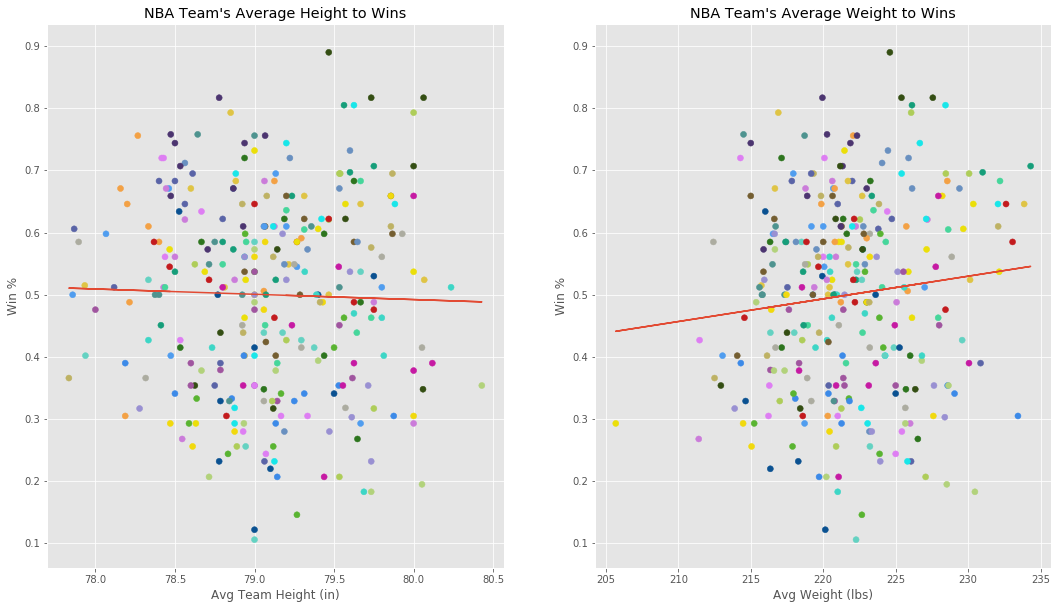

In [14]:
def avg_team_feats_to_wins(df):
    fig = plt.figure(figsize=(18,10)) # Size the figure
    # Configure the plot to have two columns to compare side by side
    # and set the labels for the first plot
    ax1 = fig.add_subplot(1,2,1,
                         title="NBA Team's Average Height to Wins",
                         xlabel="Avg Team Height (in)",
                         ylabel="Win %")
    # Plot the data
    ax1.scatter(x=df['AVG_PLAYER_HEIGHT_INCHES'],
               y=df['W_PCT'],
               color=df['Color'])
    
    # Prep our data for a LinearRegression. The X training data needs to be
    # a 2D array in the event that you are performing a multivariate regresssion
    X = [[x] for x in df['AVG_PLAYER_HEIGHT_INCHES']]
    model = LinearRegression().fit(X, df['W_PCT']) # Fit the model
    predicted_W = model.predict(X) # Calculate the models predictions to be used
                                   # as points for our line of best fit
    ax1.plot(df['AVG_PLAYER_HEIGHT_INCHES'], predicted_W) # Plot the line of best fit
    
    # Calculate the r value
    print("Avg Height-Wins: r = " + str(df['AVG_PLAYER_HEIGHT_INCHES'].corr(df['W_PCT'], method="pearson")))

    # Configure the second plot
    ax2 = fig.add_subplot(1,2,2,
                         title="NBA Team's Average Weight to Wins",
                         xlabel="Avg Weight (lbs)",
                         ylabel="Win %")
    # Plot the data
    ax2.scatter(x=df['AVG_PLAYER_WEIGHT'],
                y=df['W_PCT'],
               color=df['Color'])
    
    # Prep our data for a LinearRegression
    X = [[x] for x in df['AVG_PLAYER_WEIGHT']]
    model = LinearRegression().fit(X, df['W_PCT']) # Fit the model
    predicted_W = model.predict(X) # Calculate predictions
    ax2.plot(df['AVG_PLAYER_WEIGHT'], predicted_W) # Plot line of best fit
    
    # Calculate r value
    print("Avg Weight-Wins: r = " + str(df['AVG_PLAYER_WEIGHT'].corr(df['W_PCT'], method="pearson")))
    
    plt.show()
    
avg_team_feats_to_wins(means_team_df)

Oof. As expected, the results don't look too promising. The correlation between weight and win percentage is incredibly weak, and the correlation between height and win percentage is negative! Even without the regression lines there seems to be no correlation. These models just won't do. 

Let's not lose hope yet, surely there is more we can do to find a relationship between these two attributes.

### Standardizing the Data

After some thinking, I found some holes in our first approach. When calculating our averages, we gave equal weighting to superstars and bench players! 6'8, 250 pound LeBron James would not appreciate being equated to the status of his bench warmers. To make up for this weakness in our model, let's consider adding some other player attributes when computing our averages.

The NBA statistics glossary defines a player's usage percentage as, "the percentage of team plays used by a player when he is on the floor." This seems like it could be a good indicator of which players heights and weights should be more influential in the overall averages for each team.

To apply this factor, we are going to start by multiplying each players height and weights by their usage percentage.

In [15]:
# Create a new DataFrame with the weighted heights and weights
new_features_per_player = {} # Mapping of index to weighted height and weighted weight
for index, row in player_df.iterrows():
    # Map the data
    new_features_per_player[index] = [row['PLAYER_HEIGHT_INCHES'] * row['USG_PCT'], row['PLAYER_WEIGHT'] * row['USG_PCT']]

# Create the new DataFrame
weighted_df = pd.DataFrame.from_dict(new_features_per_player,
                                    columns=['WEIGHTED_HEIGHT', 'WEIGHTED_WEIGHT'],
                                    orient="index")
#Concatenate the player DataFrame with our new DataFrame
weighted_player_df = pd.concat([player_df, weighted_df], axis=1)
weighted_player_df.head()

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,PLAYER_HEIGHT,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,COLLEGE,COUNTRY,...,OREB_PCT,DREB_PCT,USG_PCT,TS_PCT,AST_PCT,SEASON_START,SEASON_END,Color,WEIGHTED_HEIGHT,WEIGHTED_WEIGHT
0,201166,Aaron Brooks,1610612745,HOU,24.0,6-0,72.0,161.0,Oregon,USA,...,0.018,0.063,0.225,0.521,0.201,2008,2009,"[0.6454350875434409, 0.05153833924708162, 0.20...",16.200,36.225
1,201189,Aaron Gray,1610612741,CHI,24.0,7-0,84.0,270.0,Pittsburgh,USA,...,0.116,0.192,0.138,0.508,0.098,2008,2009,"[0.6651587030789735, 0.6323375923687656, 0.107...",11.592,37.260
2,201151,Acie Law,1610612737,ATL,24.0,6-3,75.0,202.0,Texas A&M,USA,...,0.011,0.087,0.155,0.490,0.257,2008,2009,"[0.8391740001571977, 0.6052888788648251, 0.196...",11.625,31.310
3,200747,Adam Morrison,1610612747,LAL,24.0,6-8,80.0,205.0,Gonzaga,USA,...,0.027,0.093,0.172,0.448,0.101,2008,2009,"[0.9136478736603107, 0.22623949657881648, 0.34...",13.760,35.260
4,1502,Adonal Foyle,1610612753,ORL,34.0,6-10,82.0,270.0,Colgate,St. Vincent & Grenadines,...,0.127,0.236,0.118,0.623,0.028,2008,2009,"[0.2902099824021285, 0.6076477806195419, 0.007...",9.676,31.860


Awesome! Since these values will no longer hold any perceivable value to us, we will standardize our new field before we plot it to conceptualize the data more effectively.

In [16]:
# Find the means and standard deviations of the new columns
mean_weighted_height = weighted_player_df['WEIGHTED_HEIGHT'].mean()
std_weighted_height = weighted_player_df['WEIGHTED_HEIGHT'].std()
mean_weighted_weight = weighted_player_df['WEIGHTED_WEIGHT'].mean()
std_weighted_weight = weighted_player_df['WEIGHTED_WEIGHT'].std()

standardized_values = {}
# Iterate through each row and standardize our new values
for index, row in weighted_player_df.iterrows():
    std_height = (row['WEIGHTED_HEIGHT'] - mean_weighted_height) / std_weighted_height # Calculate standardized height
    std_weight = (row['WEIGHTED_WEIGHT'] - mean_weighted_weight) / std_weighted_weight # Calculate standardized weight
    standardized_values[index] = [std_height, std_weight] # Map values
    
# Create the new DataFrame
std_df = pd.DataFrame.from_dict(standardized_values,
                                    columns=['STD_HEIGHT', 'STD_WEIGHT'],
                                    orient="index")
#Concatenate the player DataFrame with our new DataFrame
std_player_df = pd.concat([weighted_player_df, std_df], axis=1)
std_player_df.head()

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,PLAYER_HEIGHT,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,COLLEGE,COUNTRY,...,USG_PCT,TS_PCT,AST_PCT,SEASON_START,SEASON_END,Color,WEIGHTED_HEIGHT,WEIGHTED_WEIGHT,STD_HEIGHT,STD_WEIGHT
0,201166,Aaron Brooks,1610612745,HOU,24.0,6-0,72.0,161.0,Oregon,USA,...,0.225,0.521,0.201,2008,2009,"[0.6454350875434409, 0.05153833924708162, 0.20...",16.200,36.225,0.489541,-0.294125
1,201189,Aaron Gray,1610612741,CHI,24.0,7-0,84.0,270.0,Pittsburgh,USA,...,0.138,0.508,0.098,2008,2009,"[0.6651587030789735, 0.6323375923687656, 0.107...",11.592,37.260,-0.652182,-0.209432
2,201151,Acie Law,1610612737,ATL,24.0,6-3,75.0,202.0,Texas A&M,USA,...,0.155,0.490,0.257,2008,2009,"[0.8391740001571977, 0.6052888788648251, 0.196...",11.625,31.310,-0.644006,-0.696311
3,200747,Adam Morrison,1610612747,LAL,24.0,6-8,80.0,205.0,Gonzaga,USA,...,0.172,0.448,0.101,2008,2009,"[0.9136478736603107, 0.22623949657881648, 0.34...",13.760,35.260,-0.115017,-0.373089
4,1502,Adonal Foyle,1610612753,ORL,34.0,6-10,82.0,270.0,Colgate,St. Vincent & Grenadines,...,0.118,0.623,0.028,2008,2009,"[0.2902099824021285, 0.6076477806195419, 0.007...",9.676,31.860,-1.126909,-0.651305


Now that we've applied our weighting system to the data and standardized our values to ease our understanding, let's see if we can achieve a higher correlation from the indivdiual attributes against the win percentage. Like before, let's start by computing the average heights and weights per team, except this time using the weighted, standardized attributes.

In [17]:
std_means_per_team_per_season = {} # Map arbitrary index to team ID, season start, average height,
                               # average weight, and team abbreviation
count = 0 # Arbitrary index
# Sort the players by season and team and iterate through the groups
for (team, season_start), grp in std_player_df.groupby(['TEAM_ID', 'SEASON_START']):
    # Map the means
    std_means_per_team_per_season[count] = [team, season_start, grp['STD_HEIGHT'].mean(), grp['STD_WEIGHT'].mean()]
    count += 1
    
# Put the new data into a data frame so it can be easily merged with our existing teams DataFrame
std_means_df = pd.DataFrame.from_dict(std_means_per_team_per_season,
                                    columns=['TEAM_ID', 'SEASON_START', 'STD_AVG_HEIGHT', 'STD_AVG_WEIGHT'],
                                    orient="index")
# Merge the dataframe, using an innerjoin (doesn't matter what type of join because the data will merge seamlessly)
std_means_team_df = means_team_df.merge(std_means_df, how = "inner", left_on = ["TEAM_ID", "SEASON_START"], right_on = ["TEAM_ID", "SEASON_START"])
std_means_team_df.head()

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,...,CFID,CFPARAMS,SEASON_START,SEASON_END,Color,AVG_PLAYER_HEIGHT_INCHES,AVG_PLAYER_WEIGHT,TEAM_ABBREVIATION,STD_AVG_HEIGHT,STD_AVG_WEIGHT
0,1610612737,Atlanta Hawks,82,47,35,0.573,48.1,36.0,78.7,0.458,...,10,Atlanta Hawks,2008,2009,"[0.9222365195955999, 0.8738632609639102, 0.034...",78.466667,227.133333,ATL,-0.186507,-0.087644
1,1610612738,Boston Celtics,82,62,20,0.756,48.5,37.5,77.2,0.486,...,10,Boston Celtics,2008,2009,"[0.9523665036207078, 0.6313527788468828, 0.270...",78.266667,222.066667,BOS,-0.025127,0.021733
2,1610612766,Charlotte Bobcats,82,35,47,0.427,48.6,35.0,76.8,0.455,...,10,Charlotte Bobcats,2008,2009,"[0.3906202091715919, 0.8242001283704017, 0.761...",79.294118,229.588235,CHA,-0.012208,0.075003
3,1610612741,Chicago Bulls,82,41,41,0.500,48.6,38.1,83.5,0.457,...,10,Chicago Bulls,2008,2009,"[0.3053336388520115, 0.5782602572338978, 0.559...",78.923077,215.769231,CHI,-0.021513,-0.108802
4,1610612739,Cleveland Cavaliers,82,66,16,0.805,48.2,36.9,78.7,0.468,...,10,Cleveland Cavaliers,2008,2009,"[0.09475904868062346, 0.9017009461138868, 0.91...",79.625000,228.437500,CLE,0.041774,0.113028


And once again, let's plot our new attributes and fit a regression line over them.

Std Avg Height-Wins: r = -0.10566028064996794
Std Avg Weight-Wins: r = -0.04971127794819678


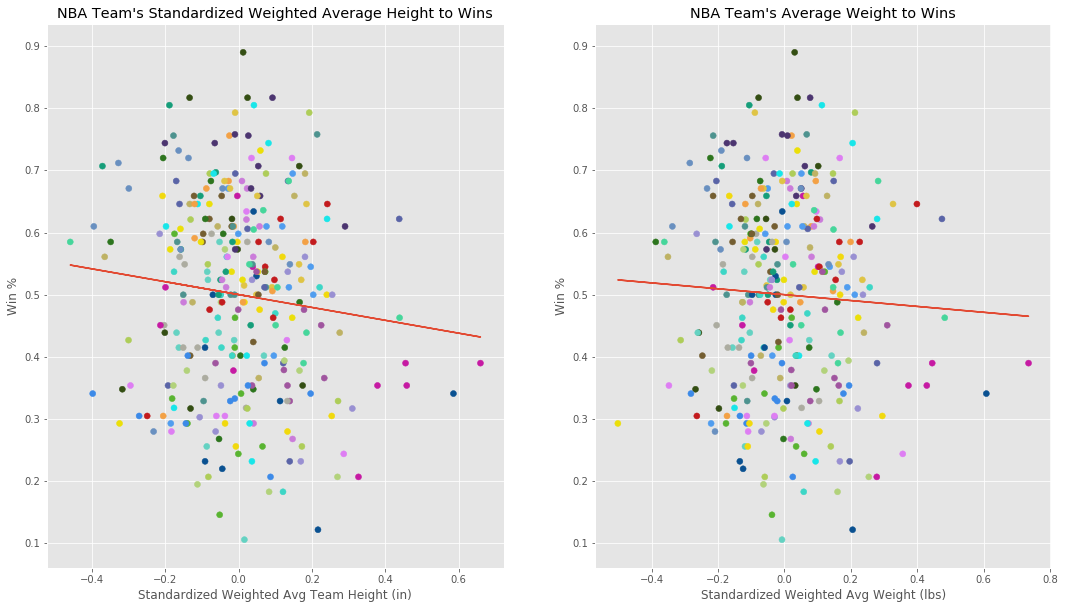

In [18]:
def avg_team_feats_to_wins(df):
    fig = plt.figure(figsize=(18,10)) # Size the figure
    # Configure the plot to have two columns to compare side by side
    # and set the labels for the first plot
    ax1 = fig.add_subplot(1,2,1,
                         title="NBA Team's Standardized Weighted Average Height to Wins",
                         xlabel="Standardized Weighted Avg Team Height (in)",
                         ylabel="Win %")
    # Plot the data
    ax1.scatter(x=df['STD_AVG_HEIGHT'],
               y=df['W_PCT'],
               color=df['Color'])
    
    # Prep our data for a LinearRegression. The X training data needs to be
    # a 2D array in the event that you are performing a multivariate regresssion
    X = [[x] for x in df['STD_AVG_HEIGHT']]
    model = LinearRegression().fit(X, df['W_PCT']) # Fit the model
    predicted_W = model.predict(X) # Calculate the models predictions to be used
                                   # as points for our line of best fit
    ax1.plot(df['STD_AVG_HEIGHT'], predicted_W) # Plot the line of best fit
    
    # Calculate the r value
    print("Std Avg Height-Wins: r = " + str(df['STD_AVG_HEIGHT'].corr(df['W_PCT'], method="pearson")))

    # Configure the second plot
    ax2 = fig.add_subplot(1,2,2,
                         title="NBA Team's Average Weight to Wins",
                         xlabel="Standardized Weighted Avg Weight (lbs)",
                         ylabel="Win %")
    # Plot the data
    ax2.scatter(x=df['STD_AVG_WEIGHT'],
                y=df['W_PCT'],
               color=df['Color'])
    
    # Prep our data for a LinearRegression
    X = [[x] for x in df['STD_AVG_WEIGHT']]
    model = LinearRegression().fit(X, df['W_PCT']) # Fit the model
    predicted_W = model.predict(X) # Calculate predictions
    ax2.plot(df['STD_AVG_WEIGHT'], predicted_W) # Plot line of best fit
    
    # Calculate r value
    print("Std Avg Weight-Wins: r = " + str(df['STD_AVG_WEIGHT'].corr(df['W_PCT'], method="pearson")))
    
    plt.show()
    
avg_team_feats_to_wins(std_means_team_df)

Darn, our correlation actually became more negative (maybe we are on to something?). We could give accept the null hypothesis right here and now, but you know what they say, "energy and persistence conquers all things" (I definitely didn't just Google that proverb) so let's give it one last shot. Currently, all we have been testing is player attributes independently. Let's bring these guys together and see if there is any chemistry between them.

### Grasping for a Well Fitting a Model

To take one last swing at the plate, let's try a few variations of the fields we have in a linear regression model and throw some other terms in there to see where it takes us.

To begin, let's just see what the model using height and weight spits out for it's r-squared value.

In [19]:
model = smf.ols(formula='W_PCT ~ AVG_PLAYER_HEIGHT_INCHES + AVG_PLAYER_WEIGHT', data=std_means_team_df).fit()
print(model.rsquared)

model = smf.ols(formula='W_PCT ~ STD_AVG_HEIGHT + STD_AVG_WEIGHT', data=std_means_team_df).fit()
print(model.rsquared)

model = smf.ols(formula='W_PCT ~ STD_AVG_HEIGHT + STD_AVG_WEIGHT + FG_PCT', data=std_means_team_df).fit()
print(model.rsquared)

model = smf.ols(formula='W_PCT ~ STD_AVG_HEIGHT + STD_AVG_WEIGHT + FG_PCT + FG3_PCT + FT_PCT', data=std_means_team_df).fit()
print(model.rsquared)

model = smf.ols(formula='W_PCT ~ STD_AVG_HEIGHT + STD_AVG_WEIGHT + FG_PCT + FG3_PCT + FT_PCT + REB_RANK + PTS_RANK + STL + BLK + PTS', data=std_means_team_df).fit()
print(model.rsquared)

model = smf.ols(formula='W_PCT ~ FG_PCT + FG3_PCT + FT_PCT + REB_RANK + PTS_RANK + STL + BLK + PTS', data=std_means_team_df).fit()
print(model.rsquared)

0.021279973644315886
0.026661217745750587
0.42338498316255124
0.46376562486909145
0.5914389547658948
0.585649415578156


Clearly height and weight alone fail to yield any promising predictions into a teams success. As we add more fields related to the actual game, like field goal percentage, we see an immediate spike in the effectiveness of our model. It is interesting to see that after adding a ridiculous amount of factors into the regression, and then taking out height and weight factor, the rsquared values slightly diminishes, which I am willing to write off as a small win on this adventure.

# Conclusion

Unfortunately, today we had to accept the null hypothesis that a teams player physique has very little impact towards its success, at least over the past 10 full seasons. In hindsight, the low number of players can easily allow one outlying player to skew a team's averages, therefore making the number increasingly arbitrary. Yet, we still learned a great deal as to how well distributed the makeup of basketball teams shape up to be. The shockingly low variation in teams' average player physique certainly surprised me and sparked my curiousity into other aspects of the game. Perhaps height and weight don't have a substantial impact at the scope of the entire team, but at individual positions play a pivotal role throughout the sport. Maybe there is even a magical ratio of player heights connected by each position. The possibilities are endless. 

Ultimately, basketball is game highly dependent on skill. Even if there were a trend in team's physique, the grueling hours of hardwork that each player puts in ends up being the deciding factor as to how well a team performs. Until we can start recording statistics on the mental drive of professional athletes, predicting success will always fall substantially far from exact.